In [1]:
import torch
import torch.nn.functional as F

### Adding Context

Previously in bigrams we considered the probability of a character given the previous character (hence the bi in bigram). Now we'd like to add more context, Lets consider the probabilty of the next character given three previous characters.

In [2]:
names = open("names.txt", "r").read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(names)

32033

In [4]:
### Build the vocab ###

#find all characters in our dataset
vocab = sorted(list(set(''.join(names))))
vocab.insert(0, ".")

#create vocab mappings
char_to_idx = {char: idx for idx, char in enumerate(vocab)}
idx_to_char = {idx: char for idx, char in enumerate(vocab)}

In [5]:
context_len = 3
X, Y = [], []

for name in names[:5]:
    #initalise context with "." characters (index 0)
    context = [0] * context_len
    
    print(name)
    for char in name + ".": # add end character to the name
        y = char_to_idx[char]
        X.append(context)
        Y.append(y)
        print(f'{"".join(idx_to_char[idx] for idx in context)} ---> {idx_to_char[y]} | {context} ---> {y}')

        #shift the context (like a rolling window)
        context = context[1:] + [y]
    
    print(end='\n')

#store as tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e | [0, 0, 0] ---> 5
..e ---> m | [0, 0, 5] ---> 13
.em ---> m | [0, 5, 13] ---> 13
emm ---> a | [5, 13, 13] ---> 1
mma ---> . | [13, 13, 1] ---> 0

olivia
... ---> o | [0, 0, 0] ---> 15
..o ---> l | [0, 0, 15] ---> 12
.ol ---> i | [0, 15, 12] ---> 9
oli ---> v | [15, 12, 9] ---> 22
liv ---> i | [12, 9, 22] ---> 9
ivi ---> a | [9, 22, 9] ---> 1
via ---> . | [22, 9, 1] ---> 0

ava
... ---> a | [0, 0, 0] ---> 1
..a ---> v | [0, 0, 1] ---> 22
.av ---> a | [0, 1, 22] ---> 1
ava ---> . | [1, 22, 1] ---> 0

isabella
... ---> i | [0, 0, 0] ---> 9
..i ---> s | [0, 0, 9] ---> 19
.is ---> a | [0, 9, 19] ---> 1
isa ---> b | [9, 19, 1] ---> 2
sab ---> e | [19, 1, 2] ---> 5
abe ---> l | [1, 2, 5] ---> 12
bel ---> l | [2, 5, 12] ---> 12
ell ---> a | [5, 12, 12] ---> 1
lla ---> . | [12, 12, 1] ---> 0

sophia
... ---> s | [0, 0, 0] ---> 19
..s ---> o | [0, 0, 19] ---> 15
.so ---> p | [0, 19, 15] ---> 16
sop ---> h | [19, 15, 16] ---> 8
oph ---> i | [15, 16, 8] ---> 9
phi ---> a | [16, 8,

In [6]:
print(f"{X.shape} with dtype: {X.dtype}")
print(f"{Y.shape} with dtype: {Y.dtype}")

torch.Size([32, 3]) with dtype: torch.int64
torch.Size([32]) with dtype: torch.int64


In [7]:
# create our embedding "table". embedding dimension is 2. we embed each character into a two dimensional space
C = torch.randn((27, 2))

SIDE NOTE: we can think of this "lookup" in the embedding table in two ways.LookupError
 1. using the indexes of the char in the vocab directly (index into the embedding table)
 2. encode the indexes into one-hot encoding (thus multiply the embedding table by the encoded indexes ) 

In [8]:
# 1st row is: ... ---> e | [0, 0, 0] ---> 5

print(f"First way: \nX[0] = {X[0]} gives y[0] = {Y[0]}. Indexing into C[[0, 0, 0]] = \n{C[X[0]]}")

First way: 
X[0] = tensor([0, 0, 0]) gives y[0] = 5. Indexing into C[[0, 0, 0]] = 
tensor([[0.5285, 1.1712],
        [0.5285, 1.1712],
        [0.5285, 1.1712]])


In [9]:
# second way
F.one_hot(X[0], num_classes=27).float() @ C

tensor([[0.5285, 1.1712],
        [0.5285, 1.1712],
        [0.5285, 1.1712]])

In [10]:
C[X[0]].shape
# 3 context chars x 2 embedding dims

torch.Size([3, 2])

In [11]:
C[X[0]].view((6,)) # reshape/view this tensor as a (6,) to feed as input into the 1st hidden layer

tensor([0.5285, 1.1712, 0.5285, 1.1712, 0.5285, 1.1712])

In [12]:
#-1 means pytorch will work out that dim based on the other dim (i.e. we want 6 columns, tell us how many rows we need)
x1 = C[X].view(-1, 6) # C[X] (batch_shape, input_shape)=(32, 3, 2) where input_shape=(3, 2) [context_dim, emb_dim]

x1.shape #x1 (batch_dim, 6) as we have asked pytorch to view it this way (Concatinate the context dim into one row)

torch.Size([32, 6])

In [13]:
#hiddden layer with tanh activation
w1 = torch.randn((6, 100)) #dim=(input_dim, num_of_neurons)
b1 = torch.randn((100)) #dim=(num_of_neurons) each neuron has one bias
h1 = torch.tanh(x1@w1 + b1) # CHECK BROADCASTING

In [14]:
#BROADCASTING CHECK
# x1@w1 = (32, 100) (batch_dim, input_shape)x(input_shape, num_of_neurons)=(batch_dim, num_of_neurons)
#    b1 = (100) row vector of bias' one bias for each neuron!

#Align to the right
#         (32, 100)
#         (  , 100)

# broadcast b1. the right most matches GOOD. the left most will be matched to i.e. broadcasted to 32 dim
# b1_bcast (32, 100) i.e. b1 row vector copied along the rows 32 times! EXACTLY WHAT WE WANT!


In [15]:
h1.shape # (batch_num, input_shape)x(input_shape, num_of_neurons) = (batch_shape, num_of_neurons)

torch.Size([32, 100])

In [16]:
## Second and final hidden layer
# GOAL: output a prob dist over our vocab where the highest prob will be the prediction for the next character (given our context window)

w2 = torch.randn((100, 27)) #input:(batch_dim, input_shape)=(32, 100) we want output_dim (i.e. number of neurons) to be len(vocab)=27 
b2 = torch.randn((27)) # each neuron has a bias

logits = h1@w2 + b2 #Checked broadcasting earlier, b2 is a row vector, which we want copied for each example in our batch (down the batch dim i.e. the rows)

In [17]:
# softmax activation.
# This converts the 27 dim row rector into a probability dist

its = logits.exp()
prob_dists = its / its.sum(1, keepdim=True) # sum over 1st dimension (len(vocab)) keepdim means we want column vector (each chara to be divided by the sum - copy across the 27 columns!)
prob_dists.shape # (batch_dim, len(vocab))

torch.Size([32, 27])

In [18]:
# We end up with a prob dist over the vocab for each of our 32 examples
# we can pick out the probabilty of the targets Y

# recall Y is the index in our vocab for the next character, so our model should be assigning high prob to that index
# i.e.  ... ---> e | [0, 0, 0] ---> 5 so the 5th index for the first example should have a high prob (after training)

prob_of_targets = prob_dists[torch.arange(0, 32), Y] # Y represents the columns we wanyt to pick out, the index in the vocab. we have 32 examples.
prob_of_targets

tensor([1.0667e-06, 4.3625e-15, 1.9284e-08, 6.8693e-05, 2.1361e-12, 1.1772e-16,
        3.1834e-06, 1.8966e-13, 3.3036e-01, 3.1330e-14, 1.0726e-08, 7.3815e-15,
        4.0031e-11, 2.8697e-03, 2.1147e-09, 1.8099e-12, 1.7014e-12, 2.4005e-11,
        9.9698e-12, 5.0755e-07, 1.8800e-10, 2.8402e-14, 8.9178e-08, 5.0398e-06,
        3.9876e-15, 1.9958e-12, 4.8077e-16, 5.2822e-10, 4.5968e-08, 4.4709e-07,
        3.2599e-09, 2.1586e-10])

so prob of picking 5th index in our vocab is 7.6933e-09. the higher these probabilties the better the model

In [19]:
## measure the loss (ve- average log likelihood)

loss = -prob_of_targets.log().mean() 
loss

tensor(21.9689)

Note: We use the mean log likelihood rather than the sum of the log likelihoods to ensure that batch size (N) is independent from the learning rate. In the mean we divide through by N, removing the infulence of batch size. If we took the sum, then the loss is influenced by the batch_size, which during gradient decent, where we mutliply through by a learning rate, will require different learning rates for different batch_sizes. (unless you data set splits perfectly into an equal number of batches - will cause a problem). Thus the mean is the way!  

In [20]:
## Bring it all together

## Parameters ##
C = torch.randn((27, 2))

w1 = torch.randn((6, 100)) 
b1 = torch.randn((100)) 

w2 = torch.randn((100, 27)) 
b2 = torch.randn((27)) 

parameters = [C, w1, b1, w2, b2]

In [21]:
print(f"We have {sum(p.nelement() for p in parameters)} elements")

We have 3481 elements


In [22]:
## to run the backwards pass we need to set requires_grad().
for p in parameters:
    p.requires_grad = True

In [23]:
## forward pass ##

emb = C[X] # (32, 3, 2)
#x1 =  #(32, 6)
h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1) #(32, 100)
logits = h1 @ w2 + b2 #(32, 27)
# its = logits.exp()
# prob_dists = its / its.sum(1, keepdim=True)
# prob_of_targets = prob_dists[torch.arange(0, 32), Y]
# loss = -prob_of_targets.log().mean()
loss = F.cross_entropy(logits, Y)
loss

tensor(13.0772, grad_fn=<NllLossBackward0>)

In [24]:
F.cross_entropy(logits, Y)

tensor(13.0772, grad_fn=<NllLossBackward0>)

the cross entropy loss is the same as the negative log likelihood in the case where there is only one correct char.
all other positions in the cross entopry loss will be zero. 
pytorch will regonise that you are sending in indexes (representing one correct char - rather than say three, and set y_trues all to zero, appart from the index)


benifits of using cross entropy
1. the intermedery steps are usually computed in a fused kernel and so are very effecient (no extra tensors are made, like in our imp)
2. the backwards pass is more efficent since (through analytical mathematics we can derive the exact derivative) and so dont need to work the dervivate out for each of the intermediate steps - like we would if we did our implementation
   (and example of this can be seen in tanh - we know the exact derivative (through analytical methods its (1-t**2))
3. our previous method can not handle large logits (since exp(100) is inf - **This is called overflow**) to solve this, because of the normalisation, we can add/minus any arbitary number. take the number to be the max of the logits and minus. that way we get zero or negative numbers... problem solved (only possible due to normalisation)

In [25]:
## backward pass ##
for p in parameters:
    p.grad = None
loss.backward()

In [26]:
## update the parameters ##
for p in parameters:
    p.data += -0.1 * p.grad

In [27]:
## run another forward pass having updated and see the loss decrease ##
emb = C[X] # (32, 3, 2)
#x1 =  #(32, 6)
h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1) #(32, 100)
logits = h1 @ w2 + b2 #(32, 27)
# its = logits.exp()
# prob_dists = its / its.sum(1, keepdim=True)
# prob_of_targets = prob_dists[torch.arange(0, 32), Y]
# loss = -prob_of_targets.log().mean()
loss = F.cross_entropy(logits, Y)
loss.item()

10.031877517700195

#### Bring it all together | 32 data Examples (from the 1st five words)

In [28]:
for p in parameters:
    p.requires_grad = True

In [29]:
iterations = 1000
for _ in range(iterations):
    ## FORWARD PASS ##
    emb = C[X] # (32, 3, 2)
    h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1) #(32, 6)x(6, 100) gives (32, 100)
    logits = h1 @ w2 + b2 #(32, 27)
    loss = F.cross_entropy(logits, Y) #softmax is applied internally
    

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    for p in parameters:
        p.data += -0.1 * p.grad
print(f"Final Loss: {loss.item():.3f}")

Final Loss: 0.257


Here we get a very low loss because we are overfitting. we have 32 examples but 3481 parameters. Notice though that we dont get exatly zero, well that because we have inputs that give multiple output values in our training set. so for exampl ... as an input gives e (for the first name emma), a (for the second name ava), and so on, we have multiple names that start with different letters.

#### Bring it all together | ALL data Examples

In [30]:
context_len = 3
X, Y = [], []

for name in names:
    #initalise context with "." characters (index 0)
    context = [0] * context_len
    
    for char in name + ".": # add end character to the name
        y = char_to_idx[char]
        X.append(context)
        Y.append(y)

        #shift the context (like a rolling window)
        context = context[1:] + [y]

#store as tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

In [31]:
print(f"{X.shape} with dtype: {X.dtype}")
print(f"{Y.shape} with dtype: {Y.dtype}")

torch.Size([228146, 3]) with dtype: torch.int64
torch.Size([228146]) with dtype: torch.int64


In [32]:
## Parameters ##
C = torch.randn((27, 2))
w1 = torch.randn((6, 100)) 
b1 = torch.randn((100)) 
w2 = torch.randn((100, 27)) 
b2 = torch.randn((27)) 
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

In [33]:
iterations = 10
for _ in range(iterations):
    ## FORWARD PASS ##
    emb = C[X] # (228146, 3, 2)
    h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1) #(228146, 6)x(6, 100) gives (228146, 100)
    logits = h1 @ w2 + b2 #(228146, 27)
    loss = F.cross_entropy(logits, Y) #softmax is applied internally
    print(f"Loss: {loss.item():.3f}")

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    for p in parameters:
        p.data += -0.1 * p.grad
print(f"Final Loss: {loss.item():.3f}")

Loss: 18.389
Loss: 16.853
Loss: 15.610
Loss: 14.563
Loss: 13.666
Loss: 12.913
Loss: 12.284
Loss: 11.722
Loss: 11.199
Loss: 10.711
Final Loss: 10.711


Much Slower! because we are training over the whole dataset (228146 examples) in each iteration, which is too much work. Lets split into mini batches.

It is better to move in the approximate gradient direction and take more steps than it is to get the exact gradient and take fewer steps!

We approximate the true value of the gradient by calculating the gradient for our mini batch (its a batch not all of the data points hence why its an approximation!!).

In [34]:
## Parameters ##
C = torch.randn((27, 2))
w1 = torch.randn((6, 100)) 
b1 = torch.randn((100)) 
w2 = torch.randn((100, 27)) 
b2 = torch.randn((27)) 
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

In [35]:
iterations = 1000
mini_batch_size = 32

for _ in range(iterations):

    # construct mini batch (randomly select 32 examples with replacement)
    # select 32 integers (which represent the indexes of our training set)
    ix = torch.randint(0, X.shape[0], (mini_batch_size,))

    ## FORWARD PASS ##
    emb = C[X[ix]] # (32, 3, 2)
    h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1) #(32, 6)x(6, 100) gives (32, 100)
    logits = h1 @ w2 + b2 #(32, 27)
    loss = F.cross_entropy(logits, Y[ix]) #softmax is applied internally

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    for p in parameters:
        p.data += -0.1 * p.grad
print(f"Final Loss For that mini Batch final chosen mini-batch (the last one! [the hundreth one]) [ix]: {loss.item():.3f}")

Final Loss For that mini Batch final chosen mini-batch (the last one! [the hundreth one]) [ix]: 3.053


In [36]:
# Run the forward pass on the whole data to get the full model loss

## FORWARD PASS ##
emb = C[X] # <-- evaluating all of X
h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1)
logits = h1 @ w2 + b2
loss = F.cross_entropy(logits, Y) #<-- All of Y
print(f"Model Loss (after iterating over mini batches) {loss.item():.3f}")

Model Loss (after iterating over mini batches) 2.662


### A way to explore the learning rate in the Upgrade step

In [37]:
## Parameters ##
C = torch.randn((27, 2))
w1 = torch.randn((6, 100)) 
b1 = torch.randn((100)) 
w2 = torch.randn((100, 27)) 
b2 = torch.randn((27)) 
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

iterations = 1000 
mini_batch_size = 32

## Construct Learning rates ##
lr_linear =  torch.linspace(0.001, 1, iterations)
lr_exp_trans = torch.linspace(-3, 0, iterations)
lr_exp = 10**lr_exp_trans # -3 because 10**-3 = 0.001 and 0 because 10**0 = 1

# keep track of the learning rates used; so we can plot
lr_idx = []
lr_loss = []


for i in range(iterations):#reversed(range(iterations)):

   
    ix = torch.randint(0, X.shape[0], (mini_batch_size,))

    ## FORWARD PASS ##
    emb = C[X[ix]] # (32, 3, 2)
    h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1) #(32, 6)x(6, 100) gives (32, 100)
    logits = h1 @ w2 + b2 #(32, 27)
    loss = F.cross_entropy(logits, Y[ix]) #softmax is applied internally

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    lr = lr_exp[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    #track the learning rates and the loss
    lr_idx.append(lr)
    lr_loss.append(loss.item())
print(f"Final Loss For that mini Batch final chosen mini-batch (the last one! [the hundreth one]) [ix]: {loss.item():.3f}")

Final Loss For that mini Batch final chosen mini-batch (the last one! [the hundreth one]) [ix]: 9.177


Text(0.5, 1.0, 'Starts small and gets large | jumps are exponential (so loads for small values, few for large) | time dir -->')

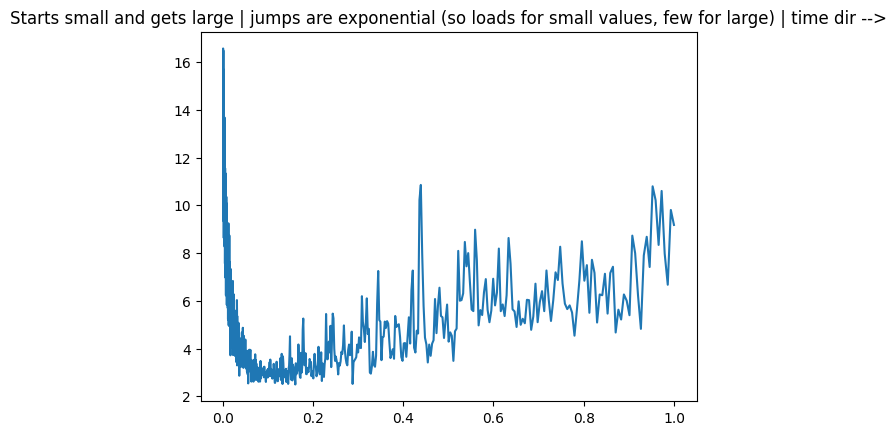

In [38]:
import matplotlib.pyplot as plt

plt.plot(lr_idx, lr_loss)
plt.title("Starts small and gets large | jumps are exponential (so loads for small values, few for large) | time dir -->")

Text(0.5, 1.0, 'here we label the x-axis with the linear space( i.e. equal appart)')

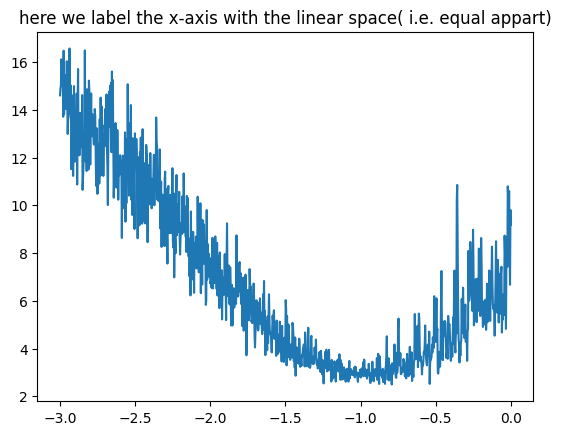

In [39]:
plt.plot(lr_exp_trans, lr_loss)
plt.title("here we label the x-axis with the linear space( i.e. equal appart)")

In [40]:
## Lets reverse the order, so going from large steps to small steps:
## Parameters ##
C = torch.randn((27, 2))
w1 = torch.randn((6, 100)) 
b1 = torch.randn((100)) 
w2 = torch.randn((100, 27)) 
b2 = torch.randn((27)) 
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

iterations = 1000 
mini_batch_size = 32

## Construct Learning rates ##
lr_linear =  torch.linspace(0.001, 1, iterations)
lr_exp_trans = torch.linspace(-3, 0, iterations)
lr_exp = 10**lr_exp_trans # -3 because 10**-3 = 0.001 and 0 because 10**0 = 1

# keep track of the learning rates used; so we can plot
lr_idx = []
lr_loss = []


for i in reversed(range(iterations)):

   
    ix = torch.randint(0, X.shape[0], (mini_batch_size,))

    ## FORWARD PASS ##
    emb = C[X[ix]] # (32, 3, 2)
    h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1) #(32, 6)x(6, 100) gives (32, 100)
    logits = h1 @ w2 + b2 #(32, 27)
    loss = F.cross_entropy(logits, Y[ix]) #softmax is applied internally

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    lr = lr_exp[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    #track the learning rates and the loss
    lr_idx.append(lr)
    lr_loss.append(loss.item())
print(f"Final Loss For that mini Batch final chosen mini-batch (the last one! [the hundreth one]) [ix]: {loss.item():.3f}")


Final Loss For that mini Batch final chosen mini-batch (the last one! [the hundreth one]) [ix]: 2.819


Text(0.5, 1.0, 'Reversed so starts large and goes small <-- time dir')

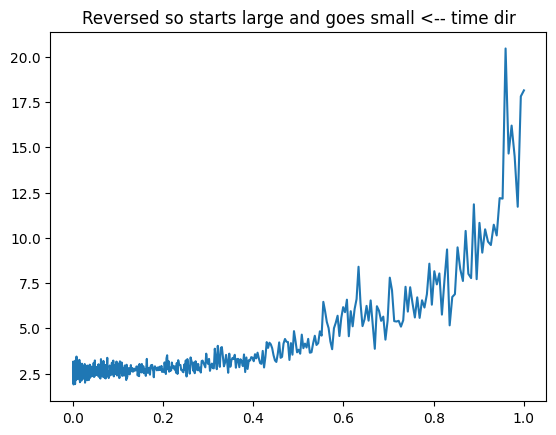

In [41]:
plt.plot(lr_idx, lr_loss)
plt.title("Reversed so starts large and goes small <-- time dir")

In [42]:
# RMSprop takes larger steps when the gradient is small and small steps when there has been a consitently large history of large gradients.
# here we are doing it on an iteration basis. the first iterations we assign a large learning rate, which gets smaller as the interations go on.

### Splitting data | Training, Validation and test

* The training is for training the model (optimising the parameters). 
* The Validation is used for optimising the hyper parameters of the model (number of neurons, rate of regularization, size of embedding, etc ...)
* The test set is used to validate the performance of the model

In [43]:
def create_dataset(names, context_len=3):
    """Function to create a dataset out of a list of names given to it

    Args:
        names (list)
        context_len (int, optional):Defaults to 3.

    Returns:
        tuple: X, Y
    """

    X, Y = [], []
    for name in names:
        #initalise context with "." characters (index 0)
        context = [0] * context_len
        
        for char in name + ".": # add end character to the name
            y = char_to_idx[char]
            X.append(context)
            Y.append(y)
        
            #shift the context (like a rolling window)
            context = context[1:] + [y]

    #store as tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

In [44]:
## Split simply by indexing
import random
random.shuffle(names)
train_split = int(0.8*len(names))
val_split = int(0.9*len(names))
X_train, Y_train = create_dataset(names[:train_split])
X_val, Y_val = create_dataset(names[train_split:val_split])
X_test, Y_test = create_dataset(names[val_split:])

In [45]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

torch.Size([182497, 3]) torch.Size([182497])
torch.Size([22865, 3]) torch.Size([22865])
torch.Size([22784, 3]) torch.Size([22784])


We can now train over the training data set and see the evalutaion on the validaton, for different configurations for the network.
We find that increaseing the Linear layer (with the tanh activation) doesnt improve the network that much and we believe this is because of the embedding dim being too small (currently two dim). before I increase the embedding dimension lets visualuse it to see if the network learns any cimalrities between characters

In [46]:
### Train network ###


## Lets reverse the order, so going from large steps to small steps:
## Parameters ##
C = torch.randn((27, 2))
w1 = torch.randn((6, 100)) 
b1 = torch.randn((100)) 
w2 = torch.randn((100, 27)) 
b2 = torch.randn((27)) 
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

iterations = 50_000 
mini_batch_size = 32


for i in range(iterations):

   
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))

    ## FORWARD PASS ##
    emb = C[X_train[ix]] # (32, 3, 2)
    h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1) #(32, 6)x(6, 100) gives (32, 100)
    logits = h1 @ w2 + b2 #(32, 27)
    loss = F.cross_entropy(logits, Y_train[ix]) #softmax is applied internally

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    lr = 0.1 if i < 30_000 else 0.01 # At 30_000 iterations we shift the learing rate
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f"Current Loss: {loss.item():.3f}")

Current Loss: 18.893
Current Loss: 2.244
Current Loss: 2.565
Current Loss: 2.281
Current Loss: 2.206


In [47]:
## Run Forward pss on training set to get training loss

emb = C[X_train]
h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1)
logits = h1 @ w2 + b2 
loss = F.cross_entropy(logits, Y_train)
print(f"training loss: {loss.item():.3f}")

training loss: 2.321


In [48]:
## Run forward pass on validation data to get validation loss
emb = C[X_val]
h1 = torch.tanh(emb.view(-1, 6) @ w1 + b1)
logits = h1 @ w2 + b2 
loss = F.cross_entropy(logits, Y_val)
print(f"Validation loss: {loss.item():.3f}")

Validation loss: 2.326


Notice they are the roughly the same. This suggested there is still room for imrpovement. But before that lets visualise the embedding matrix

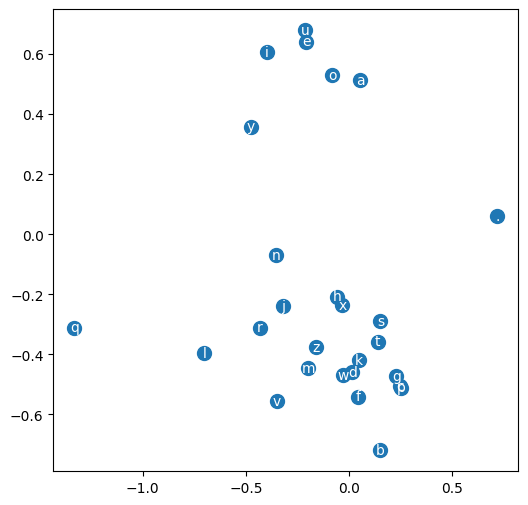

In [49]:
plt.figure(figsize=(6,6))
#plot the dims of the embedding matrix
plt.scatter(C[:, 0].data, C[:, 1].data, s=100)

#iterate through and on the dot place the letter
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), s=idx_to_char[i], ha="center", va="center", color="white")

Intrestingly, the vowels are clustered together! The model assigns similarlity to these, meaning theyre interchangeable in a sense!
There are the main cluster of letters in the center. 
there are q, ., y that are far away from the main cluster indicating that these are exceptional characters. Fasinating!!

Now lets play around with the hyper paramters to try and get a best model. here we are doiung this in a trail and error, unstructured way, but we'll learn about best practices soon. Lets just play for now!

Hyperparameters:
* Number of neurons in the linear layer
* batch_size
* number of dimensions in our embeddings
* learning rate
* context length

In [ ]:
### Train network ###

ll_neurons = 250
mini_batch_size=64
emb_dim = 10
iterations = 100_000


## Lets reverse the order, so going from large steps to small steps:
## Parameters ##
C = torch.randn((27, emb_dim))
w1 = torch.randn((3*emb_dim, ll_neurons)) 
b1 = torch.randn((ll_neurons)) 
w2 = torch.randn((ll_neurons, 27)) 
b2 = torch.randn((27)) 
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True

 
for i in range(iterations):

   
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size,))

    ## FORWARD PASS ##
    emb = C[X_train[ix]] # (mini_batch_size, 3, emb_dim) <-- 3 is the context length
    h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1) #(mini_batch_size, context_len_x_emb_dim)x(context_len_x_emb_dim, ll_neurons) gives (mini_batch_size, ll_neurons)
    logits = h1 @ w2 + b2 #(mini_batch_size, 27) <-- 27 is length of our vocab (we want to produce p(next_char over dist given the seq))
    loss = F.cross_entropy(logits, Y_train[ix]) #softmax is applied internally

    ## BACKWARDS PASS ##
    for p in parameters:
        p.grad = None
    loss.backward()

    ## UPDATE ##
    if i <= 50_000:
        lr=0.1
    elif ((i>50_000) & (i<80_000)):
        lr=0.01
    else:
        lr=0.001
    
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10_000 == 0:
        print(f"Current Loss: {loss.item():.3f}")

Current Loss: 32.432
Current Loss: 2.776
Current Loss: 2.294
Current Loss: 2.645
Current Loss: 2.226
Current Loss: 2.204
Current Loss: 2.098
Current Loss: 2.360
Current Loss: 2.197
Current Loss: 2.059


In [60]:
## Run Forward pss on training set to get training loss

emb = C[X_train]
h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1) #<-- context_len=3
logits = h1 @ w2 + b2 
loss = F.cross_entropy(logits, Y_train)
print(f"training loss: {loss.item():.3f}")

training loss: 2.141


In [61]:
## Run forward pass on validation data to get validation loss
emb = C[X_val]
h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1)
logits = h1 @ w2 + b2 
loss = F.cross_entropy(logits, Y_val)
print(f"Validation loss: {loss.item():.3f}")

Validation loss: 2.181


### Sampling from the model

The model is trained. it has adjusted its weights to best minimise the loss. Now it is time to generate new samples. Think lets pass one data point through...

In [80]:
generated_chars = []
NUMBER_OF_NAMES = 10

for _ in range(NUMBER_OF_NAMES):
    #start with ...
    context = [0] * 3
    
    while True:
        #send it through the forward pass
        emb = C[context] #(1_example, context_len, emb_dim) = (1, 3, 10)
        h1 = torch.tanh(emb.view(-1, 3*emb_dim) @ w1 + b1) #(1, ll_neuron)
        logits = h1 @ w2 + b2 #(1, 27) <-- 27 is length of our vocab 

        #now we create the prob dist (note: this was previously done internallu in cross_entorpy - but we dont want t he loss calculation, we want the prob dist)
        prob_dist = F.softmax(logits, dim=1) #logits is a row vector, so calculate over the row (i.e. across dim 1 which the columns across the columns gives over the row)

        #now we sample from the dist (a multinomal will do that for us)
        idx = torch.multinomial(prob_dist, 1).item()
        generated_chars.append(idx_to_char[idx])

        if idx == 0:
            break

        context = context[1:] + [idx]

    print("".join(generated_chars))
    generated_chars=[]

jacklin.
sina.
alicaily.
barisemasa.
azcetain.
sathleey.
lidiah.
ect.
max.
hia.
